In [1]:
strategy_name = '系统测试量化1号'

In [2]:
import sys
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
sys.path.append(r"C:\Users\xudong\Documents\github\web\dataServer")
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import copy
from funcs import *
import pandas as pd
from operator import itemgetter
import TSLPy3 as tsl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib
import matplotlib.dates as mdates

np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang
dbt = client.tinySoftData

with open(r"d:\pkl\dailyBarMtx.pkl", 'rb+') as f:
    z = pickle.load(f)
dtes = z['dtes']
dtes = np.array(dtes).astype(np.int)
tkrs = list(z['tkrs'])
open_mtx = z['open_mtx']
high_mtx = z['high_mtx']
low_mtx = z['low_mtx']
close_mtx = z['close_mtx']

k = close_mtx==0
close_mtx = zero2pre(close_mtx)
open_mtx[k]=close_mtx[k]
high_mtx[k]=close_mtx[k]
low_mtx[k]=close_mtx[k]

name = z['name']
belong = z['belong']
shenwan1 = z['shenwan1']
shenwan2 = z['shenwan2']
shenwan3 = z['shenwan3']
vol_mtx = z['vol_mtx']
amount_mtx = z['amount_mtx']


KeyboardInterrupt: 

In [ ]:
maxD = 3

In [ ]:
dd = list(dbt.minuteBarStock.find({'ticker':'SH601988', 'dateAsInt':{'$gte':int(20200106), '$lte':int(20200109)}}, {'dateTime':1}))
timeAsFloat = []
for x in dd:
    l  = str(x['dateTime']+datetime.timedelta(hours=8))
    dl = float(l[0:4]+l[5:7]+l[8:10]+'.'+l[11:13]+l[14:16]+l[17:19])
    timeAsFloat.append(dl)
timeAsFloat=np.round(np.array(sorted(list(set([x - int(x) for x in timeAsFloat])))), 6)
timeLabels = []
dayOff = []
for i in range(maxD):
    for x in timeAsFloat:
        s = str(int(x*1e4))
        if len(s)<4:
            s='0'+s
        timeLabels.append('第'+str(i+1)+'天'+s[:2]+':'+s[2:4])
        dayOff.append(i)
timeAsFloat = list(timeAsFloat)*maxD
t = np.round(np.array(sorted(list(set([x - int(x) for x in timeAsFloat])))), 6)
maxM = t.shape[0] * maxD

In [ ]:
trades = list(db.strategyBackTestTrades.find({'strategy_name':strategy_name}))
tradesUsed = []
Po = []
Ph = []
Pl = []
Pc = []
for (i,x) in enumerate(trades):
    #if (x['name'] in list(name)):
    p = list(name).index(x['name'])
    ticker = tkrs[p]
    d0 = x['dateIn']
    q = list(dtes).index(d0)
    j = np.min((q+maxD, dtes.shape[0]-1))
    d1 = dtes[j]
    dd = list(dbt.minuteBarStock.find({'ticker':ticker, 'dateAsInt':{'$gte':int(d0), '$lt':int(d1)}}, {'open':1, 'high':1, 'low':1,'close':1, 'dateTime':1}).sort([('dateTime',1)]))
    if dd==[]:
        continue
    tradesUsed.append(x)
    q = np.array([x['open'] for x in dd])
    print(i, '/', len(trades),len(q),dd[0]['dateTime'],dd[-1]['dateTime'])
    z = np.min((len(q),maxM))
    m = np.zeros(maxM)
    m[:z] = q[:z]
    m[z:] = m[z-1]
    Po.append(m)
    #q = np.array([x['high'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Ph.append(m)
    #q = np.array([x['low'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Pl.append(m)
    #q = np.array([x['close'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Pc.append(m)


In [ ]:
Po = np.array(Po)
#Ph = np.array(Ph)
#Pl = np.array(Pl)
#Pc = np.array(Pc)

In [ ]:
#x = [str(x) for x in dateLabel]
#dateLabel
#dLabel = np.array([datetime.datetime.strptime(str(int(float(d)*1e4)), '%H%M').date() for d in x])

In [ ]:
r=Po[:,1:]/Po[:,:-1] - 1
r=np.hstack((np.zeros((r.shape[0],1)),r))
priceChange = np.mean(r,axis=0)
priceChangeStd = np.std(r, axis=0)
priceChangeStd[np.isfinite(priceChangeStd)==False]=0

In [ ]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*2
plt.figure()
plt.title('平均价格随时间变化图')
#tp = [240,245,480,505,710,990,1700]
tp = [240,245,480,505]
legends=[]
if np.max(tp)<600:
    linewidth=1
else:
    linewidth=0.25
for k in tp:
    plt.plot([k, k],[-0.023,0.013], linewidth=linewidth)
    legends.append(timeLabels[k])
plt.plot(np.cumsum(priceChange),'b-', marker="o", linewidth=0.25,markersize=0.25)
plt.plot(priceChangeStd, 'k',  linewidth=0.25, markersize=0.25)
legends.append('分钟价格回报率变化累积')
legends.append('分钟价格回报率标准差')
plt.legend(legends,bbox_to_anchor=(1.0, 1.0), loc=2, borderaxespad=0.)
plt.grid()
db.strategyMinuteBar.update_one({'strategy_name':strategy_name}, {'$set':{
    'labels':timeLabels,
    'priceChange': list(np.cumsum(priceChange)),
    'priceChangeStd': list(priceChangeStd),
    'concernPoints': tp,
    'priceType': '开盘价'
}},upsert=True)

In [ ]:
trades

In [ ]:
tradeArea=[240,505]
h = np.max(np.cumsum(r[:, :tradeArea[0]], axis=1), axis=1)
isZhangtingBeforeTradeArea = h>=0.05
p = np.sum(r[:, tradeArea[0]:tradeArea[1]], axis=1)
u = np.quantile(p,0.9)
l = np.quantile(p,0.1)
rGood = r[p>=u,:]
rBad = r[p<=l, :]
for (i,x) in enumerate(tradesUsed):
    if p[i]>u:
        print('good trade:', x['name'], x['dateIn'],p[i],isZhangtingBeforeTradeArea[i])
    if p[i]<l:
        print('bad trade:', x['name'], x['dateIn'], p[i],isZhangtingBeforeTradeArea[i])


In [ ]:
def drawPriceChange(r, title='平均价格随时间变化', tp=[240,245,480,505]):
    priceChange = np.mean(r,axis=0)
    priceChangeStd = np.std(r, axis=0)
    priceChangeStd[np.isfinite(priceChangeStd)==False]=0
    plt.figure()
    plt.title(title)
    legends=[]
    if np.max(tp)<600:
        linewidth=1
    else:
        linewidth=0.25
    for k in tp:
        plt.plot([k, k],[-0.023,0.013], linewidth=linewidth)
        legends.append(timeLabels[k])
    plt.plot(np.cumsum(priceChange),'b-', marker="o", linewidth=0.25,markersize=0.25)
    plt.plot(priceChangeStd, 'k',  linewidth=0.25, markersize=0.25)
    legends.append('分钟价格回报率变化累积')
    legends.append('分钟价格回报率标准差')
    plt.legend(legends,bbox_to_anchor=(1.0, 1.0), loc=2, borderaxespad=0.)
    plt.grid()
    db.strategyMinuteBar.update_one({'strategy_name':strategy_name, title:title}, {'$set':{
        'labels':timeLabels,
        'priceChange': list(np.cumsum(priceChange)),
        'priceChangeStd': list(priceChangeStd),
        'concernPoints': tp,
        'priceType': '开盘价'
    }},upsert=True)
drawPriceChange(rGood, title='高盈利交易:'+str(rGood.shape[0])+'笔')
drawPriceChange(rBad, title='高亏损交易'+str(rBad.shape[0])+'笔')


In [ ]:
priceChangeBad = np.mean(r,axis=0)
priceChangeBadStd = np.std(r, axis=0)
priceChangeBadStd[np.isfinite(priceChangeBadStd)==False]=0

plt.figure()
plt.title('平均价格随时间变化图')
#tp = [240,245,480,505,710,990,1700]
tp = [240,245,480,505]
legends=[]
if np.max(tp)<600:
    linewidth=1
else:
    linewidth=0.25
for k in tp:
    plt.plot([k, k],[-0.023,0.013], linewidth=linewidth)
    legends.append(timeLabels[k])
plt.plot(np.cumsum(priceChange),'b-', marker="o", linewidth=0.25,markersize=0.25)
plt.plot(priceChangeStd, 'k',  linewidth=0.25, markersize=0.25)
legends.append('分钟价格回报率变化累积')
legends.append('分钟价格回报率标准差')
plt.legend(legends,bbox_to_anchor=(1.0, 1.0), loc=2, borderaxespad=0.)
plt.grid()
db.strategyMinuteBar.update_one({'strategy_name':strategy_name}, {'$set':{
    'labels':timeLabels,
    'priceChange': list(np.cumsum(priceChange)),
    'priceChangeStd': list(priceChangeStd),
    'concernPoints': tp,
    'priceType': '开盘价'
}},upsert=True)

In [ ]:
inTime = 240
otTime = 505


In [ ]:
def getPnl():
    dd = list(dtes)
    nn = list(name)
    pnl = []
    l = [x['dateIn'] for x in trades]
    c = {}
    for q in l:
        c[q]=l.count(q)
    for (i,t) in enumerate(trades):
        n = t['name']
        j = dd.index(t['dateIn'])
        print(t)
        jin = j + dayOff[inTime]
        jot = j + dayOff[otTime]
        if (jin>=len(dtes)):
            jin = len(dtes)-1
        if (jot>=len(dtes)):
            jot = len(dtes)-1
        din = dtes[jin]+timeAsFloat[inTime]
        dot = dtes[jot]+timeAsFloat[otTime]
        dtIn=datetime.datetime.strptime(str(din), '%Y%m%d.%H%M')+datetime.timedelta(hours=-8)
        dtOt=datetime.datetime.strptime(str(dot), '%Y%m%d.%H%M')+datetime.timedelta(hours=-8)
        q1 = dbt.minuteBarStock.find_one({'ticker':tkrs[nn.index(n)], 'dateTime':dtIn},{'ticker':1, 'name':1, 'open':1})
        q2 = dbt.minuteBarStock.find_one({'ticker':tkrs[nn.index(n)], 'dateTime':dtOt},{'ticker':1, 'name':1, 'open':1})
        if q1==None:
            continue
        if q2==None:
            continue
        r = (q2['open']/q1['open']-1)/c[t['dateIn']]
        print(t['dateIn'], n, dtIn, dtOt,r)
        pnl.append(r)
    return pnl

In [ ]:
pnl = getPnl()

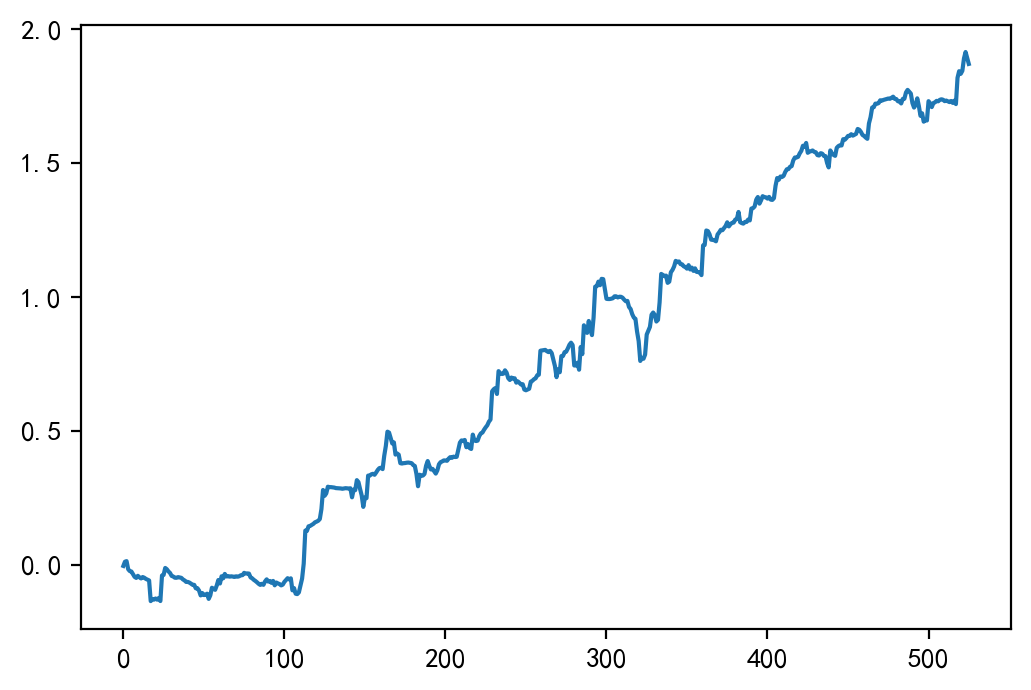

In [18]:
plt.plot(np.cumsum(pnl))

In [19]:
# %load_ext line_profiler
# #%lprun -f getPnl getPnl()